Combining the fusion.py code with the ComPat stochastic inducer, II
=======================================================
Here we will not be running the fusion code to steady state, but for dt seconds and then updating the chi.

In [1]:
%matplotlib inline
#notebook
import numpy as np
import fusion
import ComPat
import scipy.constants  
eV = scipy.constants.eV
import os
import matplotlib
if not os.getenv("DISPLAY"): matplotlib.use('Agg')
import matplotlib.pylab as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import scipy.constants
from fipy import Variable, FaceVariable, CellVariable, TransientTerm, DiffusionTerm, Viewer, meshes

**fusion.solve_Te** solves

$$\frac{3}{2}\frac{\partial}{\partial t}\left(n(\rho,t) T(\rho,t)\right) =
    \nabla_\rho \left[ n(\rho,t) \chi(\rho,t) \nabla_\rho
    (T(\rho,t))\right] + S(\rho, t)$$

with a boundary condition given by $Te_{bc}$ and an initial
uniform temperatore of 1000 eV; the quantities are

- $n(\rho,t)$ characterizes the plasma density

- $\chi(\rho,t)$ characterizes the thermal conductivity

- $S(\rho,t)$ characterizes the source

The geometry of the simulation is characterised by the minor radius
$a_0$, major radius $R_0$ and elongation $E_0$
(while the geometry is solved in the cylindrical approximation, the
actual radius used, $a$, is adjusted on the basis of $a_0$
and $E_0$).

These are the standard (default) settings for the fusion code except for setting dt=0.001 and plotting off.

In [2]:
Qe_tot=2e6        # heating power [W]
H0=0              # position of Gaussian [-]
Hw=0.1            # width of Gaussian [-]
Te_bc=100         # outer edge Te boundary condition [eV]
chi=1             # thermal diffusivity [m^2 s^{-1}]
a0=1              # minor radius [m]
R0=3              # major radius [m]
E0=1.5            # ellipticity
b_pos=0.98        # position of density pedestal [-]
b_height=6e19     # height of density pedestal [m^-3]
b_sol=2e19        # sol value for density pedestal [m^-3]
b_width=0.01      # width of density pedestal [-]
b_slope=0.01      # slope of density pedestal [?]
nr=100            # number of radial grid points
dt=0.01           # time-step [s]
plots=False       # enable FiPy plots

Set up the fusion model.

In [3]:
a = a0*np.sqrt(E0)
V = 2*np.pi * 2*np.pi*R0
mesh = meshes.CylindricalGrid1D(nr=nr, Lr=a)
Te = CellVariable(name="Te", mesh=mesh, value=1e3)
ne = CellVariable(name="ne", mesh=mesh, value=fusion.F_ped(mesh.cellCenters.value[0]/a, b_pos, b_height, b_sol, b_width, b_slope))
Qe = CellVariable(name="Qe", mesh=mesh, value=np.exp(-((mesh.cellCenters.value/a-H0)/(Hw))**2)[0])
Qe = Qe * Qe_tot/((mesh.cellVolumes*Qe.value).sum() * V)

Gi = np.cumsum(mesh.cellVolumes*Qe.value) / (mesh.cellCenters.value[0] + mesh.dx/2)
Gi = np.append([Gi[0]/2],(Gi[1:]+Gi[:-1])/2)

print('Volume = %s m^3' % (mesh.cellVolumes.sum() * V))
print('Heating power = %0.3e W' % ((mesh.cellVolumes*Qe).sum() * V))

Te.constrain(Te_bc, mesh.facesRight)

Volume = 88.8264396098042 m^3
Heating power = 2.000e+06 W


Now set up the values for the stochastization model

In [4]:
s2 = 0.2; s3 = 0.2; d2 = 10; d3 = 10
N1 = 10; N2 = 90; N3 = 30
l1 = np.log10(Gi[Gi.shape[0]//2])
l2 = l1; l3 = l1
x1 = l1; x2 = l1**2

alpha = 0.01
NITER = 1000
T = dt*(np.arange(NITER)+1)

Run the model for NITER steps.

- the initial chi is the default (1.0)
- one step is performed
- the updated temperature profile is used to recalculate chi
- another step is performed, chi is recalculated, and this is then repeated

In [5]:
if plots: viewer = Viewer(vars=(Te), title='Heating power = %0.3e W\nchi = %s' % (Qe.cellVolumeAverage.value * V, chi), datamin=0, datamax=5000)

chi_run = chi
l1_c = x1/10
x1_c = x1/10

Te_history = []
runs = {}
for N in np.arange(0,NITER):
    eqI = TransientTerm(coeff=scipy.constants.e*ne*1.5) == DiffusionTerm(coeff=scipy.constants.e*ne*chi_run) + Qe
    eqI.solve(var=Te, dt=dt)
    if plots: viewer.plot()
    Te_history.append(Te.value.copy())
#    Gd = -np.gradient(Te.value, mesh.cellCenters.value[0]) * ne.value * eV
    runs[N] = {}
    runs[N]['x'], runs[N]['mean'], runs[N]['std'], runs[N]['xrange'], runs[N]['x1'], runs[N]['x2'] = ComPat.randomize(N1, N2, N3, l1=l1_c, l2=l2, l3=l3, s2=s2, s3=s3, d2=d2, d3=d3, x1=x1_c, x2=x2, alpha=alpha)
    x1_c = runs[N]['x1']
    l1_c = x1_c
#    runs[N]['chi'] = 10 ** runs[N]['x1'] / Gd[Gd.shape[0]//2]
    runs[N]['chi'] = 10 ** runs[N]['x1'] / Gi[Gi.shape[0]//2]
    chi_run = runs[N]['chi']

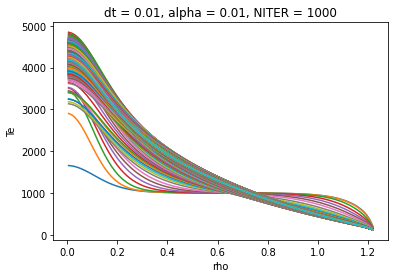

In [6]:
plt.figure()
Te_all =  np.array(Te_history)
plt.plot(mesh.cellCenters.value[0], Te_all.T)
plt.xlabel('rho')
plt.ylabel('Te')
plt.title('dt = %s, alpha = %s, NITER = %s' % (dt, alpha, NITER));

## Central Te versus iteration number

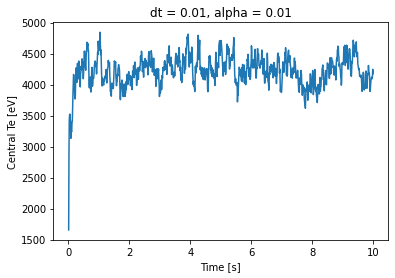

In [7]:
plt.figure()
plt.plot(T, Te_all[:,0])
plt.xlabel('Time [s]')
plt.ylabel('Central Te [eV]')
plt.title('dt = %s, alpha = %s' % (dt, alpha))
plt.savefig('Te_0_dt=%s_alpha=%s.png' % (dt, alpha))

## Flux versus the iteration number, together with steady state "target" flux (determined by integration of the source term).

All iterations: flux mean = 27514.525090835286, std-dev = 4872.975032223785, ref = 27305.779091160664


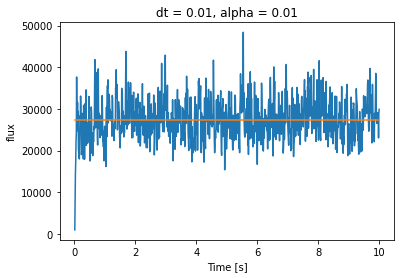

In [8]:
plt.figure()
plt.plot(T, 10**np.array([r['x1'] for r in runs.values()]))
plt.xlabel('macro iteration')
plt.ylabel('flux')
plt.plot([T.min(),T.max()], [Gi[Gi.shape[0]//2], Gi[Gi.shape[0]//2]])
plt.xlabel('Time [s]')
plt.ylabel('flux')
plt.title('dt = %s, alpha = %s' % (dt, alpha))
print('All iterations: flux mean = %s, std-dev = %s, ref = %s' % 
      ((10**np.array([r['x1'] for r in runs.values()])).mean(), 
       (10**np.array([r['x1'] for r in runs.values()])).std(),
       Gi[Gi.shape[0]//2]))

## Histogram of the central Te over the complete set of iterations

All iterations: Te_0 mean = 4220.189900240978, std-dev = 246.14999065351648


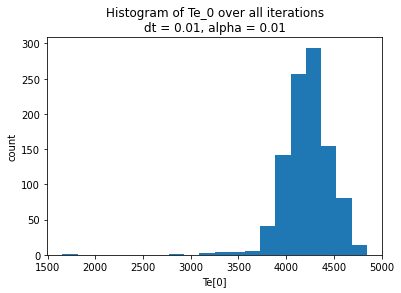

In [9]:
plt.figure()
plt.hist(Te_all[:,0], bins=20)
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('Histogram of Te_0 over all iterations\ndt = %s, alpha = %s' % (dt, alpha))
print('All iterations: Te_0 mean = %s, std-dev = %s' % (np.mean(Te_all, axis=0)[0], np.std(Te_all, axis=0)[0]))

## Histogram of the central Te over the last 50% of the iterations

Last 50% iterations: Te_0 mean = 4225.358672434727, std-dev = 212.35576736844513


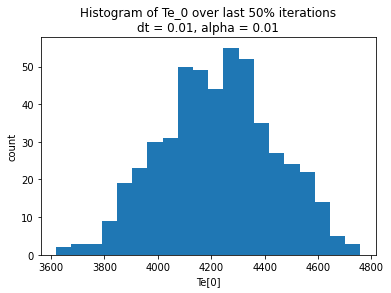

In [10]:
plt.figure()
plt.hist(Te_all[NITER//2:,0], bins=20)
plt.xlabel('Te[0]')
plt.ylabel('count')
plt.title('Histogram of Te_0 over last 50%% iterations\ndt = %s, alpha = %s' % (dt, alpha))
print('Last 50%% iterations: Te_0 mean = %s, std-dev = %s' % (np.mean(Te_all[NITER//2:], axis=0)[0], np.std(Te_all[NITER//2:], axis=0)[0]))

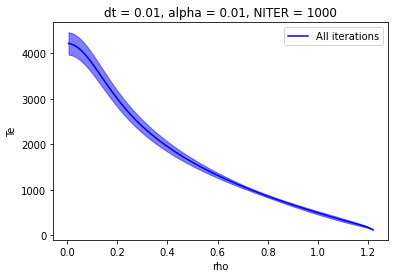

In [11]:
plt.figure()
plt.plot(mesh.cellCenters.value[0], Te_all.mean(axis=0), 'b', label='All iterations')
plt.fill_between(mesh.cellCenters.value[0], 
                 Te_all.mean(axis=0)-Te_all.std(axis=0), 
                 Te_all.mean(axis=0)+Te_all.std(axis=0), color='blue', alpha=0.5)
plt.xlabel('rho')
plt.ylabel('Te')
plt.legend(loc=0)
plt.title('dt = %s, alpha = %s, NITER = %s' % (dt, alpha, NITER));

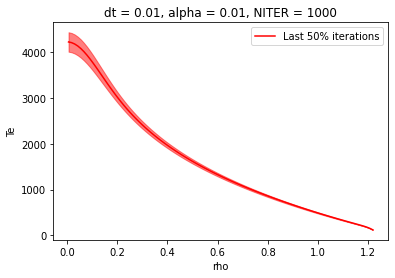

In [12]:
plt.figure()
plt.plot(mesh.cellCenters.value[0], Te_all[NITER//2:].mean(axis=0), 'r', label='Last 50% iterations')
plt.fill_between(mesh.cellCenters.value[0], 
                 Te_all[NITER//2:].mean(axis=0)-Te_all[NITER//2:].std(axis=0), 
                 Te_all[NITER//2:].mean(axis=0)+Te_all[NITER//2:].std(axis=0), color='red', alpha=0.5)
plt.xlabel('rho')
plt.ylabel('Te')
plt.legend(loc=0)
plt.title('dt = %s, alpha = %s, NITER = %s' % (dt, alpha, NITER));